In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Thu Jan 18 16:59:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   42C    P0    67W / 300W |  16828MiB / 80994MiB |      9%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.blse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.z_activation = F.tanh
hp.activation = F.sigmoid

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from tqdm import tqdm

log_sigmas = []
for _ in tqdm(range(1000)):
    p_samples1 = (torch.rand(hp.M, 1)*2-1).cuda()
    p_samples2 = (torch.rand(hp.N, 1)*2-1).cuda()
    log_sigmas.append(get_optimum_log_sigma(p_samples1, p_samples2, -10, 10, temperature=1.0))
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.48it/s]

-2.929292929292929


In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [8]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-9e-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 0


### Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.0651], device='cuda:0', grad_fn=<ExpBackward0>)


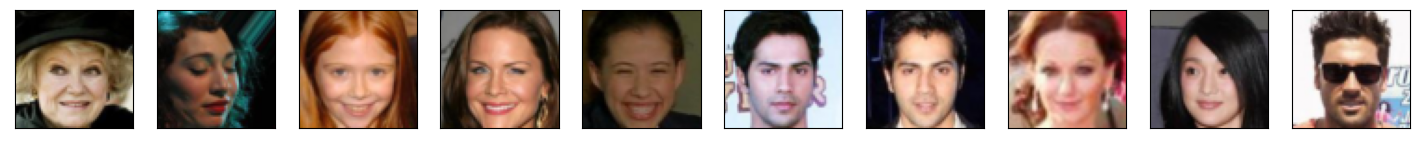

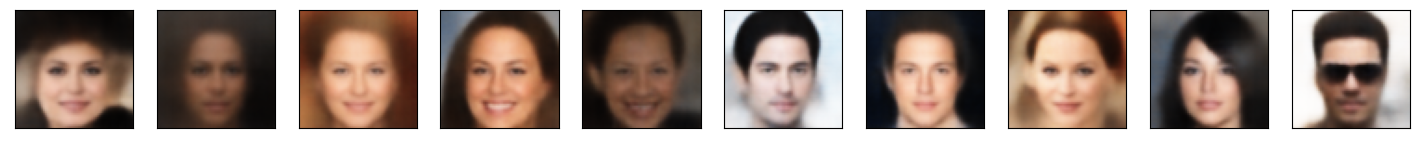

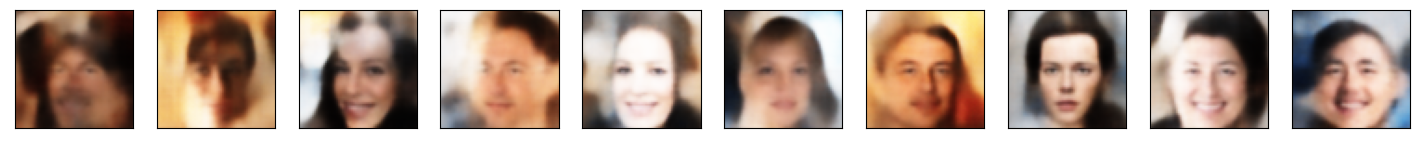

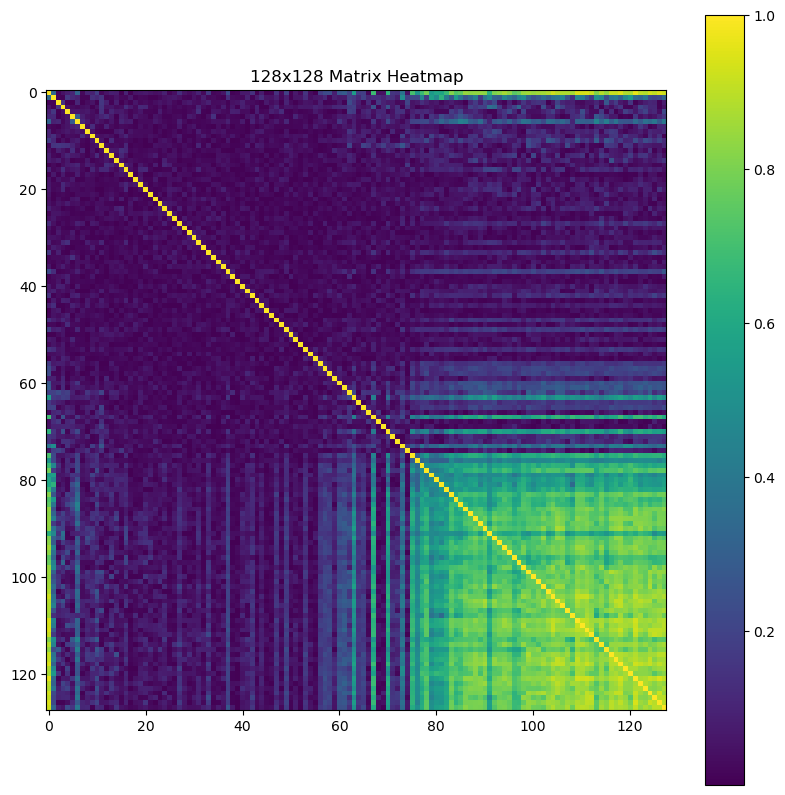

9001
lse_loss -0.6720651984214783
recon_loss 0.010143383406102657
9002
lse_loss -0.6689650416374207
recon_loss 0.010314024984836578
9003
lse_loss -0.6709631085395813
recon_loss 0.010003386065363884
9004
lse_loss -0.6694825887680054
recon_loss 0.0098536666482687
9005
lse_loss -0.668664813041687
recon_loss 0.011575049720704556
9006
lse_loss -0.668875515460968
recon_loss 0.010034377686679363
9007
lse_loss -0.6669888496398926
recon_loss 0.009689672850072384
9008
lse_loss -0.6685211658477783
recon_loss 0.010045832023024559
9009
lse_loss -0.669357180595398
recon_loss 0.010110665112733841
9010
lse_loss -0.6720338463783264
recon_loss 0.010884354822337627
9011
lse_loss -0.6696280241012573
recon_loss 0.010015862993896008
9012
lse_loss -0.670134961605072
recon_loss 0.011036030948162079
9013
lse_loss -0.6705664992332458
recon_loss 0.009942757897078991
9014
lse_loss -0.6699957847595215
recon_loss 0.010632693767547607
9015
lse_loss -0.669115424156189
recon_loss 0.00941401720046997
9016
lse_loss -0.6

9126
lse_loss -0.6701900362968445
recon_loss 0.0112094571813941
9127
lse_loss -0.6678598523139954
recon_loss 0.010679255239665508
9128
lse_loss -0.6701214909553528
recon_loss 0.010159625671803951
9129
lse_loss -0.6713697910308838
recon_loss 0.010084996931254864
9130
lse_loss -0.6694629788398743
recon_loss 0.009791485965251923
9131
lse_loss -0.6701366901397705
recon_loss 0.00997393298894167
9132
lse_loss -0.6722124814987183
recon_loss 0.010490573942661285
9133
lse_loss -0.6692451238632202
recon_loss 0.010158386081457138
9134
lse_loss -0.6699403524398804
recon_loss 0.009982462041079998
9135
lse_loss -0.6699870228767395
recon_loss 0.00939006358385086
9136
lse_loss -0.6680642366409302
recon_loss 0.009580684825778008
9137
lse_loss -0.6683515310287476
recon_loss 0.010380631312727928
9138
lse_loss -0.6652671098709106
recon_loss 0.010118886828422546
9139
lse_loss -0.6700782775878906
recon_loss 0.009654248133301735
9140
lse_loss -0.6685255765914917
recon_loss 0.010963257402181625
9141
lse_loss 

9251
lse_loss -0.6707533001899719
recon_loss 0.010470561683177948
9252
lse_loss -0.6733419895172119
recon_loss 0.011502056382596493
9253
lse_loss -0.6707131862640381
recon_loss 0.010231328196823597
9254
lse_loss -0.6720306873321533
recon_loss 0.011230498552322388
9255
lse_loss -0.6695440411567688
recon_loss 0.010551592335104942
9256
lse_loss -0.6719262599945068
recon_loss 0.011118059977889061
9257
lse_loss -0.6680455207824707
recon_loss 0.011574692092835903
9258
lse_loss -0.6694621443748474
recon_loss 0.011335606686770916
9259
lse_loss -0.6702301502227783
recon_loss 0.010464931838214397
9260
lse_loss -0.671259880065918
recon_loss 0.01030747964978218
9261
lse_loss -0.671126127243042
recon_loss 0.011495403945446014
9262
lse_loss -0.6701721549034119
recon_loss 0.010501362383365631
9263
lse_loss -0.6713749766349792
recon_loss 0.01072177104651928
9264
lse_loss -0.668870747089386
recon_loss 0.00944907870143652
9265
lse_loss -0.6668837070465088
recon_loss 0.010061973705887794
9266
lse_loss -0

9376
lse_loss -0.670543909072876
recon_loss 0.010999413207173347
9377
lse_loss -0.6718662977218628
recon_loss 0.00916450284421444
9378
lse_loss -0.6693177819252014
recon_loss 0.011445674113929272
9379
lse_loss -0.6672170162200928
recon_loss 0.010131945833563805
9380
lse_loss -0.6714251041412354
recon_loss 0.009491577744483948
9381
lse_loss -0.6687788963317871
recon_loss 0.009202471002936363
9382
lse_loss -0.6682826280593872
recon_loss 0.010461686179041862
9383
lse_loss -0.6692072153091431
recon_loss 0.009852672927081585
9384
lse_loss -0.6710165143013
recon_loss 0.010737262666225433
9385
lse_loss -0.6693360805511475
recon_loss 0.009854262694716454
9386
lse_loss -0.669827938079834
recon_loss 0.009778914973139763
9387
lse_loss -0.6706386208534241
recon_loss 0.00933779589831829
9388
lse_loss -0.669266402721405
recon_loss 0.009915357455611229
9389
lse_loss -0.6695903539657593
recon_loss 0.010139953345060349
9390
lse_loss -0.6702265739440918
recon_loss 0.009843732230365276
9391
lse_loss -0.6

9501
lse_loss -0.6698580980300903
recon_loss 0.011373083107173443
9502
lse_loss -0.6718355417251587
recon_loss 0.0100807910785079
9503
lse_loss -0.6727628707885742
recon_loss 0.010550305247306824
9504
lse_loss -0.6720379590988159
recon_loss 0.009607721120119095
9505
lse_loss -0.6706176996231079
recon_loss 0.009910701774060726
9506
lse_loss -0.6700994372367859
recon_loss 0.009418127126991749
9507
lse_loss -0.669303834438324
recon_loss 0.00974427442997694
9508
lse_loss -0.670583963394165
recon_loss 0.0102701336145401
9509
lse_loss -0.6675055027008057
recon_loss 0.010259754955768585
9510
lse_loss -0.6708984375
recon_loss 0.010479656979441643
9511
lse_loss -0.6658132672309875
recon_loss 0.009694797918200493
9512
lse_loss -0.6707468628883362
recon_loss 0.00979466550052166
9513
lse_loss -0.6703516840934753
recon_loss 0.008845880627632141
9514
lse_loss -0.6691327095031738
recon_loss 0.009249387308955193
9515
lse_loss -0.6706677079200745
recon_loss 0.010137316770851612
9516
lse_loss -0.6702919

9626
lse_loss -0.6732186079025269
recon_loss 0.010872035287320614
9627
lse_loss -0.6719188690185547
recon_loss 0.010782314464449883
9628
lse_loss -0.6693536639213562
recon_loss 0.009968617931008339
9629
lse_loss -0.6710678935050964
recon_loss 0.010474637150764465
9630
lse_loss -0.6682030558586121
recon_loss 0.011482303962111473
9631
lse_loss -0.6706174612045288
recon_loss 0.00901481881737709
9632
lse_loss -0.6704386472702026
recon_loss 0.010189665481448174
9633
lse_loss -0.6714940071105957
recon_loss 0.010945456102490425
9634
lse_loss -0.6671748161315918
recon_loss 0.00983645673841238
9635
lse_loss -0.6668161749839783
recon_loss 0.01016872376203537
9636
lse_loss -0.6664267182350159
recon_loss 0.010085842572152615
9637
lse_loss -0.667557954788208
recon_loss 0.009913396090269089
9638
lse_loss -0.6682356595993042
recon_loss 0.010763960890471935
9639
lse_loss -0.6698935031890869
recon_loss 0.010045718401670456
9640
lse_loss -0.6690229177474976
recon_loss 0.009422536939382553
9641
lse_loss 

9751
lse_loss -0.6707406044006348
recon_loss 0.009684129618108273
9752
lse_loss -0.6714688539505005
recon_loss 0.01069185696542263
9753
lse_loss -0.6710403561592102
recon_loss 0.009066218510270119
9754
lse_loss -0.672346830368042
recon_loss 0.01109900139272213
9755
lse_loss -0.6706772446632385
recon_loss 0.010249778628349304
9756
lse_loss -0.6685837507247925
recon_loss 0.009871993213891983
9757
lse_loss -0.6684666275978088
recon_loss 0.009479967877268791
9758
lse_loss -0.66924649477005
recon_loss 0.009772608056664467
9759
lse_loss -0.6717533469200134
recon_loss 0.009916900657117367
9760
lse_loss -0.6708725690841675
recon_loss 0.01072931569069624
9761
lse_loss -0.6701226234436035
recon_loss 0.00954517349600792
9762
lse_loss -0.6692091226577759
recon_loss 0.009853756986558437
9763
lse_loss -0.6703779697418213
recon_loss 0.010739731602370739
9764
lse_loss -0.6710394620895386
recon_loss 0.01000005193054676
9765
lse_loss -0.6713685393333435
recon_loss 0.010760880075395107
9766
lse_loss -0.6

9876
lse_loss -0.6704584360122681
recon_loss 0.009625177830457687
9877
lse_loss -0.6706773638725281
recon_loss 0.00976879894733429
9878
lse_loss -0.6676421165466309
recon_loss 0.008875563740730286
9879
lse_loss -0.6693353652954102
recon_loss 0.01231994479894638
9880
lse_loss -0.6702499389648438
recon_loss 0.01166525762528181
9881
lse_loss -0.6679762601852417
recon_loss 0.012636194936931133
9882
lse_loss -0.6706985235214233
recon_loss 0.010364213958382607
9883
lse_loss -0.6713545322418213
recon_loss 0.010654514655470848
9884
lse_loss -0.6698751449584961
recon_loss 0.009755364619195461
9885
lse_loss -0.6718015670776367
recon_loss 0.010089652612805367
9886
lse_loss -0.6706194281578064
recon_loss 0.010517223738133907
9887
lse_loss -0.6718560457229614
recon_loss 0.010753773152828217
9888
lse_loss -0.6683832406997681
recon_loss 0.010275373235344887
9889
lse_loss -0.6682041883468628
recon_loss 0.010454444214701653
9890
lse_loss -0.6718496084213257
recon_loss 0.010700894519686699
9891
lse_loss

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 9e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            corrcoef = torch.corrcoef(data['z_copy'].T).abs().data.cpu().numpy()
            # Plotting the matrix as a heatmap
            plt.figure(figsize=(10, 10))
            plt.imshow(corrcoef, cmap='viridis')
            plt.colorbar()
            plt.title('128x128 Matrix Heatmap')
            plt.show()
            
            corrcoef = np.mean(corrcoef * (1-np.eye(len(corrcoef))))
            writer.add_scalar('corrcoef', corrcoef, step)
            
            from util.mmd_penalty import mmd_penalty
            opts = {'pz_scale': 1,
                    'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
                    'pz': 'normal', # 'normal', 'sphere', 'uniform' 
                    'zdim': hp.z_dim
                   } 
            e = (torch.rand_like(data['z_copy'])*2-1)
            mmd = mmd_penalty(data['z_copy'], e, opts).item()
            writer.add_scalar('MMD', mmd, step)
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
print('done')